In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
cols = ["chrom", "pos", "ref", "alt"]

core_models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    #"LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    #"Enformer.LogisticRegression",
    #"LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    #"multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA.LLR",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression": "GPN-MSA.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression": "NT.LogisticRegression",
    "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression": "HyenaDNA.LogisticRegression",
}

dataset_models = {
    "results/gwas/matched": core_models + ["Enformer.LogisticRegression", "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression"],
    "results/eqtl/matched/ge": core_models + ["Enformer.LogisticRegression"],
    "results/eqtl/matched/leafcutter": core_models + ["SpliceAI"],
}

dataset_renaming = {
    "results/gwas/matched": "GWAS",
    "results/eqtl/matched/ge": "eQTL",
    "results/eqtl/matched/leafcutter": "sQTL",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)
            
models = gather_unique_values(dataset_models)
datasets = list(dataset_models.keys())
models, datasets

(['CADD.RawScore',
  'phyloP',
  'phastCons',
  'phyloP-Zoonomia',
  'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
  'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression',
  'InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression',
  'Enformer.LogisticRegression',
  'LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression',
  'SpliceAI'],
 ['results/gwas/matched',
  'results/eqtl/matched/ge',
  'results/eqtl/matched/leafcutter'])

In [3]:
V_ds = []
for d in datasets:
    V_d = pd.read_parquet(f"../../{d}/test.parquet")
    V_d["Dataset"] = d
    preds_path = Path(f"../../results/preds/{d}")
    for m in dataset_models[d]:
        model_name = model_renaming.get(m, m)
        model_path = preds_path / f"{m}.parquet"
        V_d[model_name] = pd.read_parquet(model_path)["score"].values
    V_ds.append(V_d)
V = pd.concat(V_ds, ignore_index=True)
models = [model_renaming.get(m, m) for m in models]
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))
V

,chrom,pos,ref,alt,pip,maf,label,gene_id,tss_dist,match_group,...,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA.LLR,GPN-MSA.LogisticRegression,NT.LogisticRegression,Enformer.LogisticRegression,HyenaDNA.LogisticRegression,exon_dist,SpliceAI
0,1,946538,G,A,0.001712,0.071586,False,ENSG00000187634,7263,205,...,-6.418,-1.000,-4.855,-7.183594,-0.782515,-0.682280,-0.374308,-0.670575,<NA>,NaN
1,1,1224105,C,T,0.001093,0.096349,False,ENSG00000078808,4489,25,...,0.359,-0.000,0.101,0.244629,-0.496645,-0.390871,-0.455918,-0.651951,<NA>,NaN
2,1,1370532,C,T,0.005503,0.124852,False,ENSG00000175756,4623,71,...,0.506,-0.001,1.178,1.122070,-0.349591,-0.512993,-0.411024,-0.606836,<NA>,NaN
3,1,1428969,T,C,0.003939,0.220696,False,ENSG00000205116,3098,120,...,1.989,-0.007,1.143,0.137207,-0.329217,-0.593589,-0.465040,-0.625453,<NA>,NaN
4,1,1797728,C,T,0.001670,0.004973,False,ENSG00000008130,17659,114,...,1.391,-0.000,0.249,0.199951,NaN,NaN,NaN,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44165,X,154843392,C,T,0.009303,0.017241,False,ENSG00000185010,<NA>,8950,...,-0.076,-0.279,-0.134,0.495117,-0.443707,-0.170278,NaN,NaN,5640,-0.0
44166,X,154864799,G,A,0.009303,0.017241,False,ENSG00000185010,<NA>,8909,...,0.163,-0.002,-0.680,1.267578,-0.391480,-0.304395,NaN,NaN,1572,-0.0
44167,X,154900519,G,C,0.009303,0.017241,False,ENSG00000185010,<NA>,8908,...,2.494,-0.000,4.428,-0.461426,-0.272337,-0.447172,NaN,NaN,568,-0.0
44168,X,155264893,T,C,0.009922,0.281606,False,ENSG00000155961,<NA>,8846,...,1.162,-0.000,0.279,-1.712891,-0.146626,-0.427843,NaN,NaN,402,NaN


In [4]:
for m in ["GPN-MSA"]:
    if m in V.columns:
        print(m)
        V[m] = -V[m].abs()

In [18]:
results = []

for i, d in enumerate(datasets):
    V_d = V[V.Dataset==d]
    V_d = V_d.dropna(subset=dataset_models[d])
    V_d = V_d[V_d.duplicated("match_group", keep=False)]
    n_pos, n_neg = V_d.label.sum(), (~V_d.label).sum()
    d_renamed = dataset_renaming[d]
    subtitle = f"{d_renamed} (n={n_pos} vs. {n_neg})"
    for m in dataset_models[d]:
        results.append([d_renamed, subtitle, m, roc_auc_score(V_d.label, -V_d[m]), i])

results = pd.DataFrame(results, columns=["Dataset", "subtitle", "Model", "AUROC", "index"]).sort_values(["index", "AUROC"], ascending=[True, False])
results

,Dataset,subtitle,Model,AUROC,index
5,GWAS,GWAS (n=1981 vs. 1981),GPN-MSA.LogisticRegression,0.735490,0
7,GWAS,GWAS (n=1981 vs. 1981),Enformer.LogisticRegression,0.715272,0
6,GWAS,GWAS (n=1981 vs. 1981),NT.LogisticRegression,0.675214,0
0,GWAS,GWAS (n=1981 vs. 1981),CADD,0.642304,0
3,GWAS,GWAS (n=1981 vs. 1981),phyloP-241-mammals,0.630604,0
1,GWAS,GWAS (n=1981 vs. 1981),phyloP-100-vertebrates,0.614643,0
4,GWAS,GWAS (n=1981 vs. 1981),GPN-MSA.LLR,0.612341,0
2,GWAS,GWAS (n=1981 vs. 1981),phastCons-100-vertebrates,0.588709,0
8,GWAS,GWAS (n=1981 vs. 1981),HyenaDNA.LogisticRegression,0.573044,0
16,eQTL,eQTL (n=9555 vs. 9555),Enformer.LogisticRegression,0.763320,1


In [25]:
palette = {
    "GPN-MSA.LogisticRegression": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT.LogisticRegression": "C4",
    "SpliceAI": "C5",
    "Enformer.LogisticRegression": "C6",
    "HyenaDNA.LogisticRegression": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
}

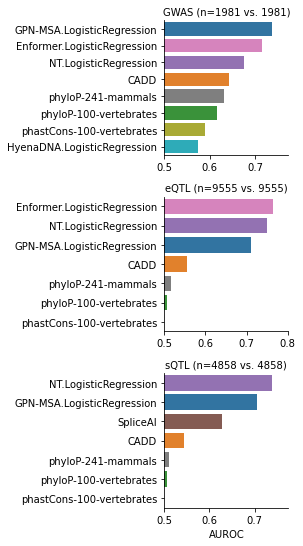

In [41]:
g = sns.catplot(
    data=results[results.Model != "GPN-MSA.LLR"],
    x="AUROC", y="Model", row="subtitle",
    kind="bar",
    height=2.5,
    aspect=1.0,
    sharex=False,
    sharey=False,
    palette=palette,
)

# Iterate over each row and set the palette
for ax, subtitle in zip(g.axes.flat, results['subtitle'].unique()):
    # Filter the data for each subtitle
    subset = results[(results.subtitle == subtitle) & (results.Model != "GPN-MSA.LLR")]
    
    # Create a barplot with the specified palette
    g2 = sns.barplot(data=subset, x="AUROC", y="Model", ax=ax, palette=palette)
    g2.set_xlabel("")
    g2.set_ylabel("")
g2.set_xlabel("AUROC")

g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);
#plt.savefig("vep_functionality.pdf", bbox_inches="tight");